# Model Predictive Control

An entire marathon! Trying to make model predictive control (slightly more advanced than LQG) work. Main reference: https://ieeexplore-ieee-org.libproxy.berkeley.edu/stamp/stamp.jsp?tp=&arnumber=8511551

Steps:

1. Keck mirror finite-element analysis: find its $\omega_D, \omega_T, d$. Will just skip over this. 
2. Convert TF to SS and augment to make $C_i, B_i$.
3. Augment with turbulence and vibrations to make $A_i$ and $C_0$.
4. Pick $R_y, R_u, u_{max}$.
5. Solve the quadratic system!

This is possibly the worst structured code I've ever written, sorry!

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal, io, linalg
# import qpsolvers
from cvxopt import solvers, matrix

from aberrations import *
from observer import *
from controller import *

f_sampling = 1000
rms = lambda data: np.sqrt(np.mean(data ** 2))

In [35]:
# step 1: Keck mirror FEA results.

# These are completely random numbers. 

w_DM = 20
w_TT = 30
z_DM = 0.6
z_TT = 0.99

def make_impulse(w, z, T=np.arange(0, 1, 0.001)):
    num = [w**2]
    den = [1, 2 * w * z, w**2]
    tf = signal.TransferFunction(num, den)
    impulse = signal.impulse(tf, T=T)
    return impulse[0], impulse[1] / sum(impulse[1])

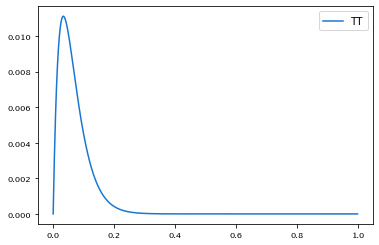

In [36]:
#plt.plot(*make_impulse(w_DM, z_DM), label="DM")
plt.plot(*make_impulse(w_TT, z_TT), label="TT")
plt.legend()

In [37]:
# I'm only going to use the TTM from now on, because one of these at a time is complicated enough

a, b, c, d = signal.tf2ss([w_TT ** 2], [1, 2 * w_TT * z_TT, w_TT ** 2]) # continuous ones
A_CM, B_CM, C_CM, D_CM = signal.cont2discrete((a, b, c, d), dt=1/f_sampling)[:4]

Took 9 iterations to get steady-state covariance.


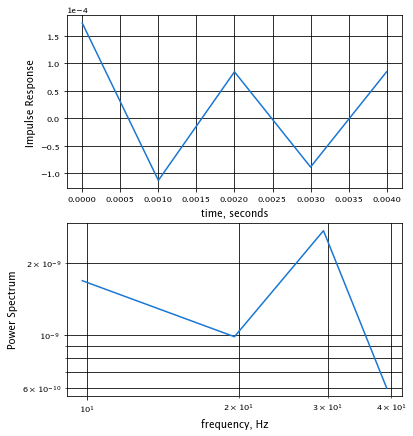

In [38]:
# now, let's import the usual Kalman filter! at first, no vibrations.

pol = np.load('../telemetry/sim_openloops_0.npy')
kfilter_turb = make_kfilter_turb(make_impulse_from_tt(pol[:100], N=5))

In [39]:
N_WFS = 2 # two frame delay
N_turb = kfilter_turb.state.size
N_CM = 2 # second order control loop model
N_state = N_WFS + N_turb + N_CM
N_frames = 10 #arbitrary
A_WFS = np.array([[0, 0], [1, 0]])
B_T = np.array([[1, 0]]).T
temp1 = B_T.dot(kfilter_turb.H)
temp2 = -B_T.dot(C_CM)

In [40]:
A_i = linalg.block_diag(A_WFS, kfilter_turb.A, A_CM)
for i, j in [(0, 2), (0, 3), (1, 2), (1, 3)]: # works with a hardcoded N_WFS = 2: edit
    A_i[i][j] = temp1[i][j-2]
    A_i[i][j+2] = temp2[i][j-2]

In [41]:
C_i = np.array([0, 1] + [0] * (N_turb + N_CM)) # measurement for the WFS?
C_0 = np.array([C_i.dot(A_i ** i) for i in range(N_frames)]) # check this again
B_i = np.zeros(N_state,)
for k in range(B_CM.size):
    B_i[N_state - B_CM.size + k] = B_CM[k]
D_0 = np.zeros((N_frames,N_frames))
for i in range(N_frames):
    for j in range(i):
        D_0[i][j] = C_i.dot(A_i ** (i - j - 1)).dot(B_i)

xT0 = pol[kfilter_turb.iters - 1: kfilter_turb.iters + 1] # last two wf errors: this gets updated in CL?
xd0 = kfilter_turb.state
xCM0 = np.zeros(2,)
x0 = np.concatenate((xT0, xd0, xCM0)).reshape((N_state,1))

In [42]:
R_y = np.identity(N_frames)
R_u = np.identity(N_frames)

In [43]:
H2 = 2 * x0.T.dot(C_0.T.dot(R_y).dot(D_0))

In [44]:
H3 = D_0.dot(R_y).dot(D_0.T) #+ R_u

In [45]:
u_max = 5 # idek
G = np.identity(N_frames)
h = np.vstack([u_max] * N_frames)
A = np.zeros((10,10))
b = np.zeros((10,1))

In [46]:
# qpsolvers.solve_qp(2 * H3, H2[0], G=G, h=h, A=a, b=b)
solvers.qp(matrix(2 * H3), matrix(H2[0]), matrix(G), matrix(h, tc='d'), solver='qpOASES')

     pcost       dcost       gap    pres   dres
 0:  6.0288e-02  4.8185e-02  1e-02  0e+00  3e+00
 1:  6.0288e-02  6.0166e-02  1e-04  0e+00  4e-02
 2:  6.0284e-02  6.0282e-02  2e-06  0e+00  5e-03
 3:  5.9999e-02  5.9998e-02  4e-07  6e-17  4e-03
 4: -2.5443e+00 -3.9577e+00  1e+00  1e-14  4e-03
 5: -5.0014e+01 -5.1428e+01  1e+00  5e-13  4e-03
 6: -6.0438e+07 -6.0438e+07  2e+00  0e+00  4e-03
 7: -7.6943e+15 -7.6943e+15  6e+05  0e+00  4e-03
 8: -9.7956e+25 -9.7956e+25  8e+13  1e+12  4e-03
 9: -1.2471e+38 -1.2471e+38  1e+24  1e-14  4e-03
10: -1.5992e+52 -1.5992e+52  1e+36  0e+00  4e-03
11: -1.4058e+68 -1.4058e+68  1e+50  8e+53  4e-03
12: -2.3248e+104 -2.3248e+104  2e+86  7e-13  1e-03
13: -3.8444e+140 -3.8444e+140  3e+122 3e+126  1e-03
14: -6.3575e+176 -6.3575e+176  5e+158  5e+58  2e+54
15: -1.0513e+213 -1.0513e+213  8e+194    inf  1e+54
16: -1.7386e+249 -1.7386e+249  1e+231    inf  5e+55
17: -2.8750e+285 -2.8750e+285  2e+267    inf  2e+55


ValueError: domain error